In [33]:
%matplotlib notebook
import sys
from pathlib import Path

SRC_ROOT_DIR_0 = '/g/wsl_projs/practical-astronomy'
SRC_ROOT_DIR_1 = '/g/wsl_projs/practical-astronomy/myastro/'
sys.path.insert(0, SRC_ROOT_DIR_0)
sys.path.insert(1, SRC_ROOT_DIR_1)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Traceback (most recent call last):
  File "/home/anybody/apps/anaconda3/envs/py37astro/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/anybody/apps/anaconda3/envs/py37astro/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [58]:
import matplotlib.pyplot as plt
from matplotlib import animation

from toolz import first

import myastro.orbit as ob
from myastro.graphics_util import OrbitsPlot
from myastro.twobodys import calc_eph_planet
import myastro.data_catalog as dc
from myastro.pert_cowells import calc_eph_by_cowells
import pandas as pd
import numpy as np



In [35]:
### Auxiliary fuction
def calc_orbits_data(eph, planets, minor_bodys, comets):
    """
    Computes the orbits of the planets, minor bodys and comets 
    
    Args:
        eph : EphemerisData
        planets : List of name of planets
        minor_bodys : List of names of minor bodys or orbital elements itself
        comets : List of names of comets bodys or orbital elements itself

    Returns :
        orbs : A dictionary where the key is the name of the body and value is a
               matrix of n,3 (n rows per 3 cols) with the heliocentric coordinates h_x, h_y, h_z
               and the index is the date of corresponding to the position.
        date_refs :  list of the dates where the heliocentric coordinates were calculated
        
    """    
    orbs = {}
    for name in planets:
        print ("Calculating data for ",name)
        df = calc_eph_planet(name, eph)
        orbs[name] = df
    for obj in minor_bodys:
        if isinstance(obj, dc.BodyElems) : 
            body_elms = obj
        else :
            print (obj)
            body_elms = dc.read_body_elms_for(obj, dc.DF_BODYS)
        print ("Calculating data for ",body_elms.name)
        df  = calc_eph_by_cowells(body_elms,eph,type='body', include_osc=False)
        orbs[body_elms.name] = df
    for name in comets:
        comet_elms = dc.read_comet_elms_for(name, dc.DF_COMETS)
        print ("Calculating data for ",comet_elms.name)
        df  = calc_eph_by_cowells(comet_elms,eph,type='comet', include_osc=False)
        orbs[name] = df
    date_refs = orbs[first(orbs.keys())]['date'].to_list()
    cols=['h_x','h_y','h_z']    
    for k, df in orbs.items():
        orbs[k] = df[cols].to_numpy() 
    
    return orbs, date_refs

In [102]:
eph = ob.EphemrisInput(from_date="2009.01.01.0",
                       to_date = "2010.12.01.0",
                       step_dd_hh_hhh = "5 00.0",
                       equinox_name = "J2000")

#PLANETS = ['Earth','Mercury','Venus','Mars']
#PLANETS = ['Jupiter','Saturn','Uranus','Neptune', 'Pluto']
PLANETS = ['Earth','Mars']
#PLANETS = []
#PLANETS = ['Jupiter','Saturn']
#MINOR_BODYS = []
#MINOR_BODYS = ['Ceres','Pallas','Juno','Vesta']
#MINOR_BODYS = ['Ceres',APOFIS]
#MINOR_BODYS = ['Ceres']
#MINOR_BODYS = []
MINOR_BODYS=['2002 NN4','2010 NY65', dc.B_2013_XA22]
#COMETS = ['1P/Halley','2P/Encke','10P/Tempel 2','C/1995 O1 (Hale-Bopp)']
#COMETS = ['C/2019 Q4 (Borisov)']
#COMETS = ['D/1993 F2-A (Shoemaker-Levy 9)']
COMETS = ['C/1988 L1 (Shoemaker-Holt-Rodriquez)'] #, 'C/1980 E1 (Bowell)','C/2019 Q4 (Borisov)']
COMETS = ['C/2019 Q4 (Borisov)']
COMETS = []

orbs,  date_refs = calc_orbits_data(eph, PLANETS, MINOR_BODYS, COMETS)

Calculating data for  Earth
Calculating data for  Mars
2002 NN4
Calculating data for  2002 NN4
2010 NY65
Calculating data for  2010 NY65
Calculating data for  2013 XA22


In [103]:
# We generate another orbs object with geocentric positions (orbs_earth)
min_rows = 2147483648
for body_name in orbs.keys():
    min_rows = min(min_rows, orbs[body_name].shape[0])
for body_name in orbs.keys():
    mtx = orbs[body_name]
    orbs[body_name] = mtx[:min_rows,:]
orbs_earth = dict()
for body_name in filter(lambda x : x!='Earth', orbs.keys()):
    orbs_earth[body_name] = orbs[body_name] - orbs['Earth']    

In [104]:
# We calculate a dataframe with the distances to earth for these objects.
df = pd.DataFrame.from_dict({k:np.linalg.norm(v,axis=1) for (k,v) in orbs_earth.items()})
df['date_ref'] = date_refs
df = df.set_index('date_ref')
# The minimun distance is calculated for each body
df.idxmin(axis = 0)


Mars         2010/01/26
2002 NN4     2010/07/10
2010 NY65    2010/06/30
2013 XA22    2009/02/20
dtype: object

In [105]:
print ("Minimun distance ")
for col in df.columns:
    print (f"{col}: {min(df[col]):0.3f} AUs      {int(min(df[col])*1.496e+8)} Kms")


Minimun distance 
Mars: 0.664 AUs      99385449 Kms
2002 NN4: 0.854 AUs      127811479 Kms
2010 NY65: 0.184 AUs      27574375 Kms
2013 XA22: 1.745 AUs      261041143 Kms


### Show 3D

<IPython.core.display.Javascript object>


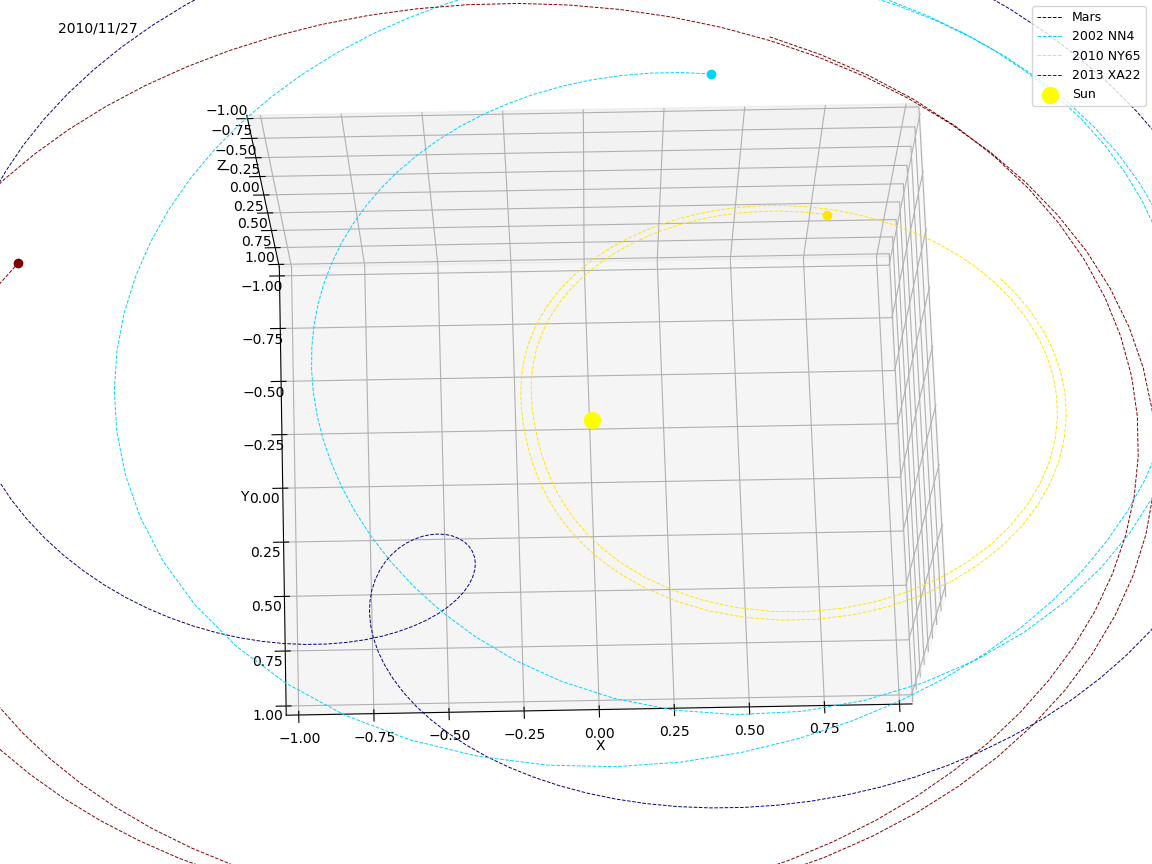

In [106]:
# normal size 6.4 x 4.8
fig = plt.figure(figsize=(11.52,8.64))
LIMITS=(-1,1)
# We need to choose if orbs or orbs_earth is shown
orbs_plot = OrbitsPlot(orbs_earth, date_refs, fig, LIMITS)
anim = animation.FuncAnimation(fig, orbs_plot.animate, init_func=orbs_plot.init, frames=len(date_refs), interval=1000, blit=False, repeat=False)
plt.show()
